In [6]:
from keras.models import load_model
import matplotlib.pyplot as plt
from utils import *
from keras import backend as K
from keras import metrics
from keras.applications.inception_v3 import InceptionV3,preprocess_input, decode_predictions
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
import urllib
from keras.preprocessing import image
from keras.models import load_model
%matplotlib inline
from PIL import Image
import numpy as np
import tensorflow as tf
from adversarial_tf import Adversarial
from cifar_keras_vgg import VGG
from utils import Utils

Using TensorFlow backend.


In [7]:
utils = Utils()
adv_cls = Adversarial()
vgg = VGG(32, 32, 3)

In [8]:
x_train, y_train, x_test, y_test = utils.load_cifar10(normalize=True)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [9]:
targets = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [10]:
model = vgg.model(dropout=True)
model.load_weights("normalized/unbalanced_0_vgg_custom.h5")
scores = model.evaluate(x_test, y_test)
acc = (scores[1] * 100)
y_pred = model.predict_classes(x_test)

 9600/10000 [===========================>..] - ETA: 0s

In [11]:
print(scores)

[0.57312975454330439, 0.80269999999999997]


In [12]:
img = x_test[0]

In [13]:
adv, perturbation = adv_cls._fgsm_k_iter(model=model,fake_class_idx=3,
                                         epsilon=0.02,n_steps=1, img=img[np.newaxis,:, :, :])

## Image

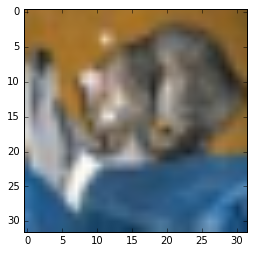

In [14]:
plt.imshow(Image.fromarray((img*255.0).astype('uint8'),'RGB'))

## Perturbation

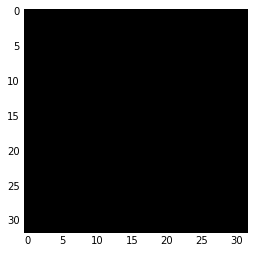

In [15]:
plt.imshow(Image.fromarray((perturbation[0]).astype('uint8'),'RGB'))

## Image + Perturbation

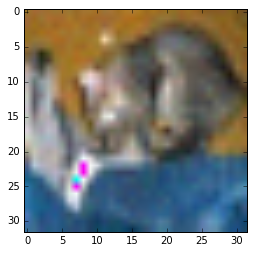

In [16]:
plt.imshow(Image.fromarray((adv[0]*255.0).astype('uint8'),'RGB'))

In [20]:
def format_results_cifar10(pred):
    
    import json
    targets = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    formatted_result = {}
    for ix,tgt in enumerate(targets):
        formatted_result[tgt] = pred[0][ix] * 100
    print(json.dumps(formatted_result, indent=1, sort_keys=True))
    
    return formatted_result

In [21]:
adv_pred = model.predict(adv)
real_pred = model.predict(img[np.newaxis,:,:,:])

In [22]:
print(format_results_cifar10(adv_pred))

{
 "Airplane": 8.290921151638031,
 "Automobile": 2.190018445253372,
 "Bird": 26.591867208480835,
 "Cat": 16.412946581840515,
 "Deer": 4.8705484718084335,
 "Dog": 14.9650439620018,
 "Frog": 15.488481521606445,
 "Horse": 5.5592648684978485,
 "Ship": 3.6118846386671066,
 "Truck": 2.0190248265862465
}
{'Cat': 16.412946581840515, 'Deer': 4.8705484718084335, 'Frog': 15.488481521606445, 'Horse': 5.5592648684978485, 'Truck': 2.0190248265862465, 'Dog': 14.965043962001801, 'Automobile': 2.1900184452533722, 'Airplane': 8.290921151638031, 'Ship': 3.6118846386671066, 'Bird': 26.591867208480835}


In [24]:
targets[adv_pred.argmax()]

'Bird'

In [25]:
print(format_results_cifar10(real_pred))

{
 "Airplane": 0.005238856829237193,
 "Automobile": 0.013934678281657398,
 "Bird": 0.2732241991907358,
 "Cat": 96.99257016181946,
 "Deer": 0.026563330902718008,
 "Dog": 1.668831706047058,
 "Frog": 0.6553926039487123,
 "Horse": 0.03401531430426985,
 "Ship": 0.30576610006392,
 "Truck": 0.02446626895107329
}
{'Cat': 96.992570161819458, 'Deer': 0.026563330902718008, 'Frog': 0.65539260394871235, 'Horse': 0.03401531430426985, 'Truck': 0.024466268951073289, 'Dog': 1.6688317060470581, 'Automobile': 0.013934678281657398, 'Airplane': 0.0052388568292371929, 'Ship': 0.30576610006392002, 'Bird': 0.27322419919073582}


In [26]:
targets[real_pred.argmax()]

'Cat'

In [27]:
numbers = [x.argmax() for x in y_test]

In [28]:
np.unique(numbers, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], dtype=int64))

In [29]:
len(utils.get_indexes_to_remove(y_test, 1000, 3))

1000

In [30]:
cats = x_test[utils.get_indexes_to_remove(y_test, 1000, 3)]

In [31]:
adv_cats = []

In [32]:
for cat in cats:
    adv, perturbation = adv_cls._fgsm_k_iter(model=model,fake_class_idx=3,
                                             epsilon=0.02,n_steps=1, img=cat[np.newaxis,:, :, :])
    adv_cats.append(adv)

KeyboardInterrupt: 

In [ ]:
adv_cats = np.reshape(adv_cats, (1000,32,32,3))

In [ ]:
preds = model.predict(adv_cats)

In [ ]:
preds = [pred.argmax() for pred in preds]

In [ ]:
np.unique(preds, return_counts=True)